# Task
Develop and compare a custom Convolutional Neural Network (CNN) and a transfer learning model for classifying dollar bills using the images from "Bill_dataset.zip". The comparison should include evaluation metrics, visualizations, and a final summary of findings and recommendations.

## Extract Dataset

### Subtask:
Extract the contents of the 'Bill_dataset.zip' file to a designated directory.

In [61]:
import zipfile
import os

zip_file_path = '/content/Bill_dataset.zip'
extraction_dir = 'Bill_dataset_extracted'

# Create the extraction directory if it doesn't exist
os.makedirs(extraction_dir, exist_ok=True)

# Open the zip file and extract its contents
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extraction_dir)

print(f"'{zip_file_path}' extracted to '{extraction_dir}'")

'/content/Bill_dataset.zip' extracted to 'Bill_dataset_extracted'


## Prepare Data Directories and Split Data



In [62]:
import shutil
import random
import os

# Define directories
train_dir = 'Bill_dataset_split/train'
test_dir = 'Bill_dataset_split/test'

# Clean up previous split directories if they exist
if os.path.exists(train_dir.split('/')[0]):
    shutil.rmtree(train_dir.split('/')[0])
    print(f"Removed existing '{train_dir.split('/')[0]}' directory.")

# Create train and test base directories
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

print(f"Created base directories: '{train_dir}' and '{test_dir}'")

test_split_ratio = 0.25 # 25% for testing

# Define the base directory where the actual denomination folders are located
base_data_dir = os.path.join(extraction_dir, 'Bill_dataset')

# Get a list of all unique dollar bill denominations (class names)
dollar_denominations = [d for d in os.listdir(base_data_dir) if os.path.isdir(os.path.join(base_data_dir, d))]

print(f"Found denominations: {dollar_denominations}")

for denomination in dollar_denominations:
    # Create corresponding subdirectories for the current denomination within both train_dir and test_dir
    os.makedirs(os.path.join(train_dir, denomination), exist_ok=True)
    os.makedirs(os.path.join(test_dir, denomination), exist_ok=True)

    # List all image files for the current denomination from its original location
    denomination_path = os.path.join(base_data_dir, denomination)
    images = [os.path.join(denomination_path, f) for f in os.listdir(denomination_path) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.tif'))]

    # Randomly shuffle the list of image files
    random.shuffle(images)

    # Calculate the number of images to allocate to the test set
    num_test_images = int(len(images) * test_split_ratio)

    # Split images into test and train sets
    test_images = images[:num_test_images]
    train_images = images[num_test_images:]

    # Move images to their respective directories
    for img_path in test_images:
        shutil.move(img_path, os.path.join(test_dir, denomination, os.path.basename(img_path)))
    for img_path in train_images:
        shutil.move(img_path, os.path.join(train_dir, denomination, os.path.basename(img_path)))

    print(f"Denomination '{denomination}': Moved {len(test_images)} to test and {len(train_images)} to train.")

print("Data split and moved successfully!")

Removed existing 'Bill_dataset_split' directory.
Created base directories: 'Bill_dataset_split/train' and 'Bill_dataset_split/test'
Found denominations: ['10', '5', '20', '1']
Denomination '10': Moved 5 to test and 17 to train.
Denomination '5': Moved 3 to test and 10 to train.
Denomination '20': Moved 9 to test and 27 to train.
Denomination '1': Moved 22 to test and 68 to train.
Data split and moved successfully!


## Load and Preprocess Image Data



In [63]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np

# Define image dimensions and batch size
img_height, img_width = 224, 224
batch_size = 32

print(f"Image dimensions set to: {img_height}x{img_width}")
print(f"Batch size set to: {batch_size}")

# Create training ImageDataGenerator with augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255, # Normalize pixel values to [0, 1]
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Create test ImageDataGenerator (only rescaling)
test_datagen = ImageDataGenerator(rescale=1./255)

# Load images from directories using flow_from_directory
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False # Do not shuffle test data
)

# Print class indices
print("\nClass indices (mapping from class name to numerical label):")
print(train_generator.class_indices)

# Print number of images found
print(f"\nFound {train_generator.samples} training images belonging to {train_generator.num_classes} classes.")
print(f"Found {test_generator.samples} testing images belonging to {test_generator.num_classes} classes.")

Image dimensions set to: 224x224
Batch size set to: 32
Found 122 images belonging to 4 classes.
Found 39 images belonging to 4 classes.

Class indices (mapping from class name to numerical label):
{'1': 0, '10': 1, '20': 2, '5': 3}

Found 122 training images belonging to 4 classes.
Found 39 testing images belonging to 4 classes.


## Build and Train CNN Model

### Subtask:
Design and compile a custom Convolutional Neural Network (CNN) model suitable for image classification. Train this CNN model using the preprocessed training data.

In [64]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Get the number of classes from the train generator
num_classes = train_generator.num_classes

# Initialize the CNN model
model = Sequential()

# First Convolutional Block
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)))
model.add(MaxPooling2D((2, 2)))

# Second Convolutional Block
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

# Third Convolutional Block
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

# Flatten the output for the fully connected layers
model.add(Flatten())

# Fully Connected Layers
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5)) # Dropout for regularization
model.add(Dense(num_classes, activation='softmax')) # Output layer with softmax for multiclass classification

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Display model summary
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 512)            │    44,302,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 44,398,148 (169.37 MB)

 Trainable params: 44,398,148 (169.37 MB)

 Non-trainable params: 0 (0.00 B)

In [66]:
epochs = 20

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=int(np.ceil(train_generator.samples / batch_size)),
    epochs=epochs,
    validation_data=test_generator,
    validation_steps=int(np.ceil(test_generator.samples / batch_size))
)

print("CNN model training complete.")

Epoch 1/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 35s 8s/step - accuracy: 0.7099 - loss: 0.7295 - val_accuracy: 0.6154 - val_loss: 0.9477
Epoch 2/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 22s 5s/step - accuracy: 0.7412 - loss: 0.7388 - val_accuracy: 0.7179 - val_loss: 0.8040
Epoch 3/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 21s 5s/step - accuracy: 0.7607 - loss: 0.6741 - val_accuracy: 0.5641 - val_loss: 1.3049
Epoch 4/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 19s 5s/step - accuracy: 0.7935 - loss: 0.5776 - val_accuracy: 0.5641 - val_loss: 2.0064
Epoch 5/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 21s 5s/step - accuracy: 0.7206 - loss: 0.6967 - val_accuracy: 0.5897 - val_loss: 1.8538
Epoch 6/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 19s 5s/step - accuracy: 0.7124 - loss: 0.6171 - val_accuracy: 0.5897 - val_loss: 1.7293
Epoch 7/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 22s 5s/step - accuracy: 0.8044 - loss: 0.5560 - val_accuracy: 0.5897 - val_loss: 2.5412
Epoch 8/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 19s 5s/step - accuracy: 0.7492 - loss: 0.6272 - val_accuracy: 0.5897 - val_loss: 1.9307
Epoch 9/

## Evaluate CNN Model

### Subtask:
Evaluate the performance of the trained custom CNN model on the unseen test data and report its accuracy.

In [67]:
print("Evaluating CNN model on test data...")
loss, accuracy = model.evaluate(test_generator)

print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

Evaluating CNN model on test data...
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 395ms/step - accuracy: 0.7078 - loss: 2.7442
Test Loss: 2.5923
Test Accuracy: 0.7179


## Build and Train Transfer Learning Model


In [68]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model

# 1. Load a pre-trained MobileNetV2 model without its top classification layer
base_model = MobileNetV2(input_shape=(img_height, img_width, 3),
                          include_top=False,
                          weights='imagenet')

# 2. Freeze the layers of the base_model
for layer in base_model.layers:
    layer.trainable = False

# 3. Add new custom classification layers on top of the pre-trained base
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x) # Hidden layer
predictions = Dense(num_classes, activation='softmax')(x) # Output layer

# 4. Create the full model
transfer_model = Model(inputs=base_model.input, outputs=predictions)

# 5. Compile the new model
transfer_model.compile(optimizer='adam',
                       loss='categorical_crossentropy',
                       metrics=['accuracy'])

# 6. Print the summary of the transfer learning model
transfer_model.summary()

Model: "functional_31"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_4[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,422,468 (9.24 MB)

 Trainable params: 164,484 (642.52 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [69]:
epochs = 10
# Train the transfer learning model
history_transfer = transfer_model.fit(
    train_generator,
    steps_per_epoch=int(np.ceil(train_generator.samples / batch_size)),
    epochs=epochs,
    validation_data=test_generator,
    validation_steps=int(np.ceil(test_generator.samples / batch_size))
)

print("Transfer learning model training complete.")

Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 19s 3s/step - accuracy: 0.4007 - loss: 1.5102 - val_accuracy: 0.2821 - val_loss: 1.2821
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - accuracy: 0.6721 - loss: 1.0083 - val_accuracy: 0.4872 - val_loss: 1.1253
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 10s 3s/step - accuracy: 0.7320 - loss: 0.7300 - val_accuracy: 0.6923 - val_loss: 0.8269
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.7635 - loss: 0.6613 - val_accuracy: 0.4103 - val_loss: 1.2346
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.8710 - loss: 0.5069 - val_accuracy: 0.6410 - val_loss: 0.8072
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.8478 - loss: 0.3989 - val_accuracy: 0.7436 - val_loss: 0.7118
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 10s 3s/step - accuracy: 0.9051 - loss: 0.3326 - val_accuracy: 0.5128 - val_loss: 1.0285
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.9345 - loss: 0.3196 - val_accuracy: 0.7692 - val_loss: 0.6849
Epoch 9/1

## Evaluate Transfer Learning Model

### Subtask:
Evaluate the performance of the trained transfer learning model on the unseen test data and report its accuracy.

In [70]:
print("Evaluating Transfer Learning model on test data...")
loss_transfer, accuracy_transfer = transfer_model.evaluate(test_generator)

print(f"Transfer Learning Test Loss: {loss_transfer:.4f}")
print(f"Transfer Learning Test Accuracy: {accuracy_transfer:.4f}")

Evaluating Transfer Learning model on test data...
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 485ms/step - accuracy: 0.5807 - loss: 0.8216
Transfer Learning Test Loss: 0.7977
Transfer Learning Test Accuracy: 0.5897


## Compare Model Performances and Visualize



Custom CNN Model Test Accuracy: 0.7179
Transfer Learning Model Test Accuracy: 0.5897


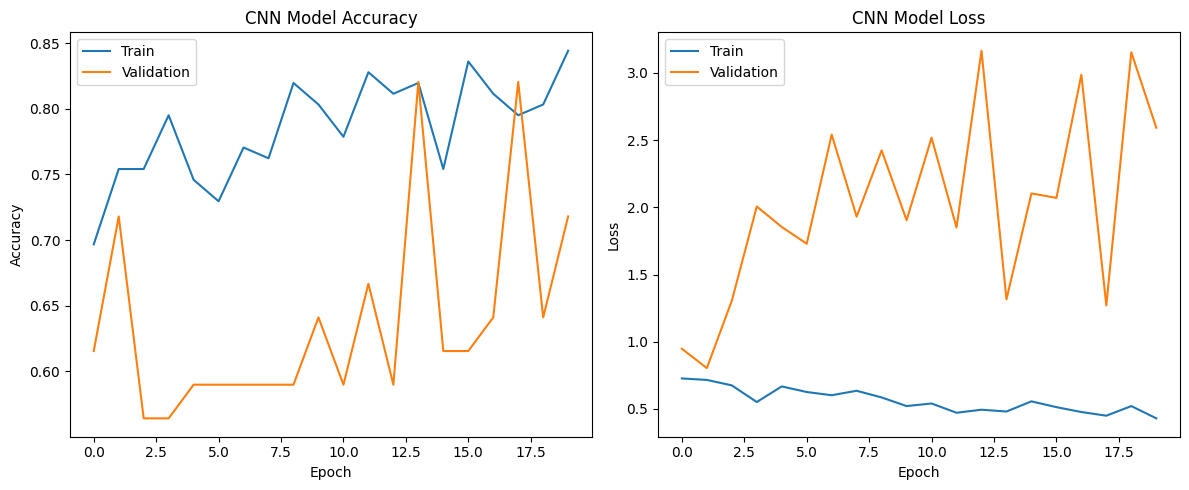

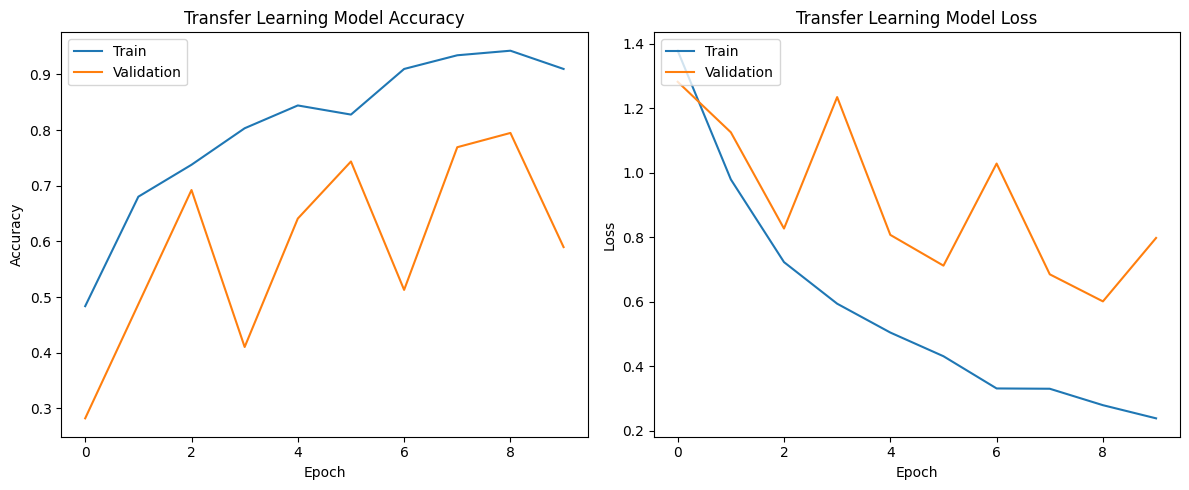

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 289ms/step


2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step


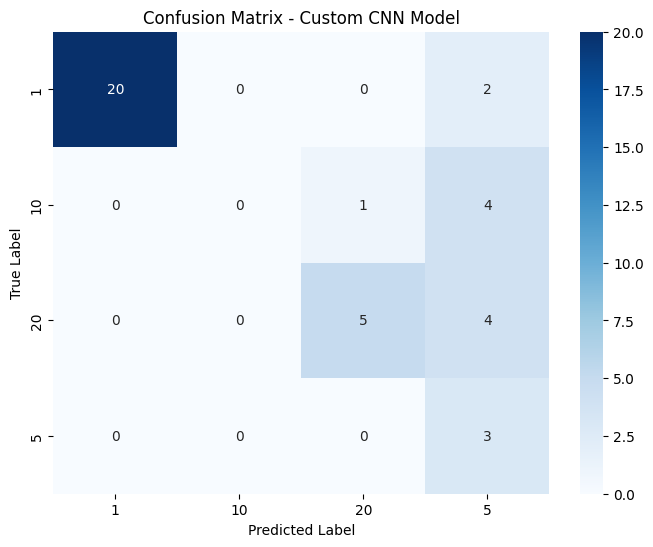

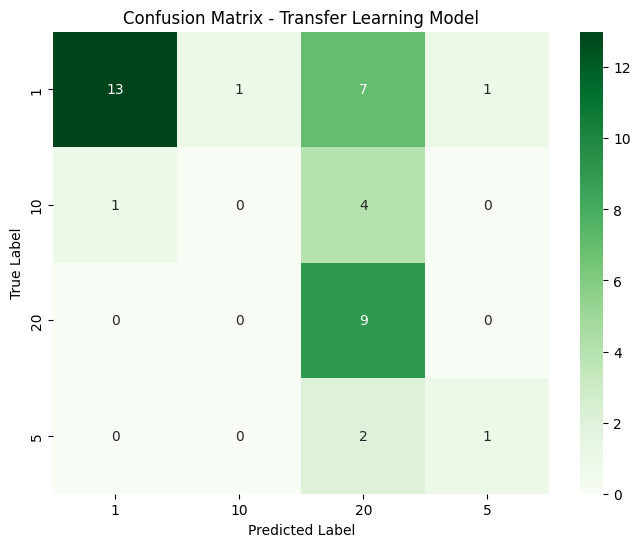

In [71]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Print Test Accuracies
print(f"Custom CNN Model Test Accuracy: {accuracy:.4f}")
print(f"Transfer Learning Model Test Accuracy: {accuracy_transfer:.4f}")

# Plot training & validation accuracy values for the CNN model
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('CNN Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values for the CNN model
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('CNN Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.tight_layout()
plt.show()

# Plot training & validation accuracy values for the Transfer Learning model
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_transfer.history['accuracy'])
plt.plot(history_transfer.history['val_accuracy'])
plt.title('Transfer Learning Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values for the Transfer Learning model
plt.subplot(1, 2, 2)
plt.plot(history_transfer.history['loss'])
plt.plot(history_transfer.history['val_loss'])
plt.title('Transfer Learning Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.tight_layout()
plt.show()

# Get predictions from the custom CNN model for confusion matrix
cnn_predictions = model.predict(test_generator)
cnn_predicted_labels = np.argmax(cnn_predictions, axis=1)

# Get predictions from the transfer learning model for confusion matrix
transfer_predictions = transfer_model.predict(test_generator)
transfer_predicted_labels = np.argmax(transfer_predictions, axis=1)

# Get true labels from the test generator
true_labels = test_generator.classes

# Get class names from the generator
class_names = list(test_generator.class_indices.keys())

# Compute confusion matrix for Custom CNN model
cm_cnn = confusion_matrix(true_labels, cnn_predicted_labels)

# Compute confusion matrix for Transfer Learning model
cm_transfer = confusion_matrix(true_labels, transfer_predicted_labels)

# Plot Confusion Matrix for Custom CNN
plt.figure(figsize=(8, 6))
sns.heatmap(cm_cnn, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix - Custom CNN Model')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Plot Confusion Matrix for Transfer Learning Model
plt.figure(figsize=(8, 6))
sns.heatmap(cm_transfer, annot=True, fmt='d', cmap='Greens', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix - Transfer Learning Model')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


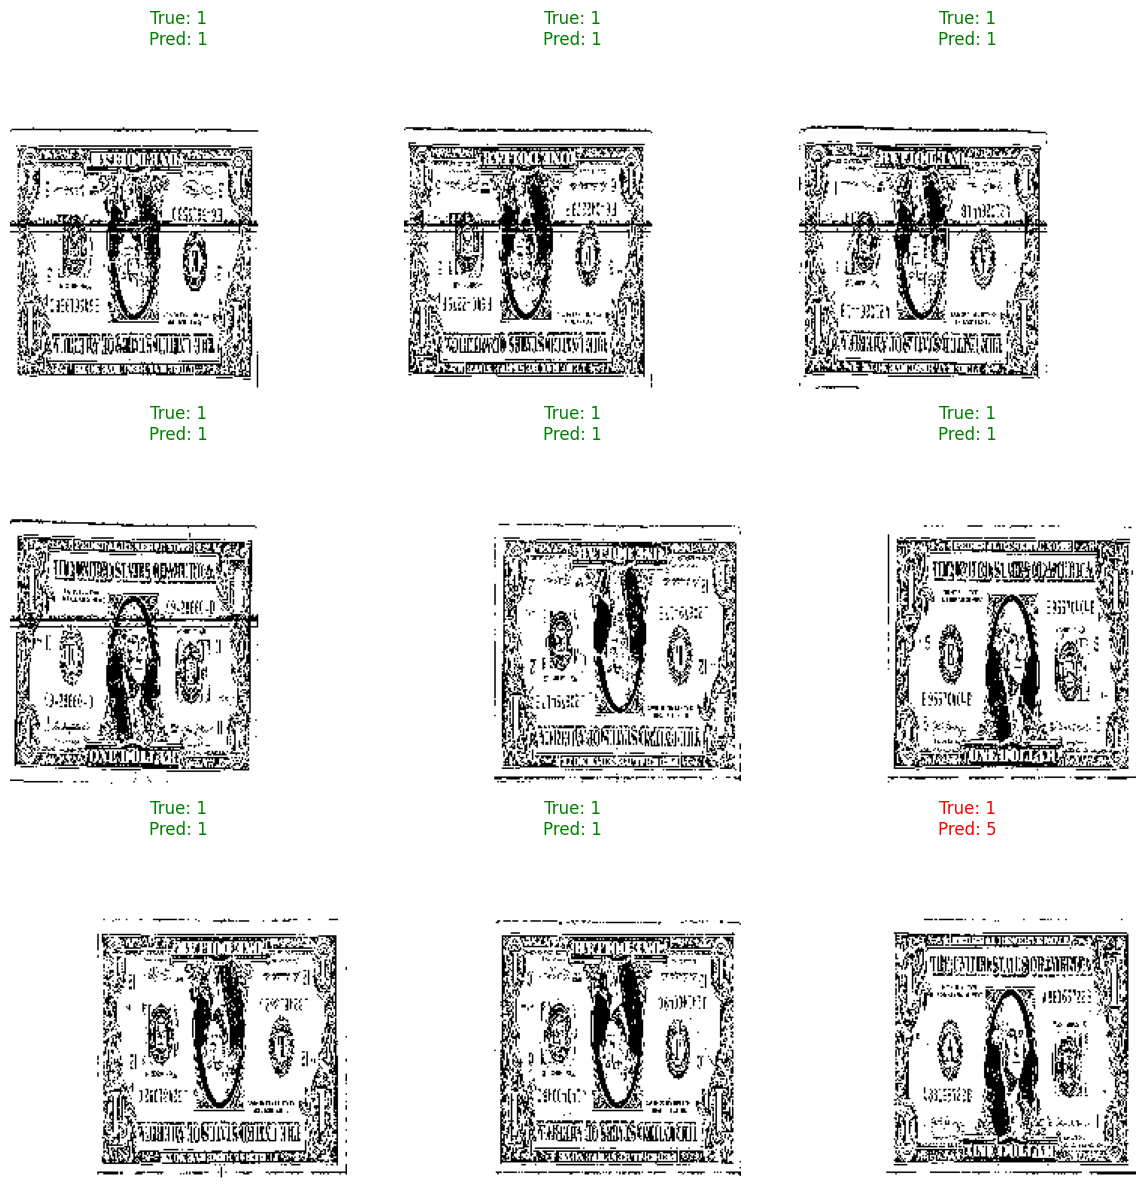

In [76]:
import matplotlib.pyplot as plt
import numpy as np

# Get class names from the generator (assuming train_generator is already defined and has class_indices)
class_names = list(train_generator.class_indices.keys())

# Reset the test generator to ensure we start from the beginning for consistent sampling
test_generator.reset()

# Get a batch of images and one-hot encoded labels from the test generator
# We'll take one batch to display a few predictions
images, true_labels_one_hot = next(test_generator)

# Make predictions using the trained transfer learning model
predictions = transfer_model.predict(images)
predicted_labels = np.argmax(predictions, axis=1)

# Convert one-hot encoded true labels back to numerical labels
true_labels = np.argmax(true_labels_one_hot, axis=1)

# Display a few example predictions
plt.figure(figsize=(12, 12))
# Display up to 9 images, or fewer if the batch size is smaller
for i in range(min(9, len(images))):
    plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])

    # Get the actual class name from the numerical label
    true_class = class_names[true_labels[i]]
    # Get the predicted class name from the numerical label
    predicted_class = class_names[predicted_labels[i]]

    # Set title color based on prediction accuracy
    color = "green" if true_class == predicted_class else "red"
    plt.title(f"True: {true_class}\nPred: {predicted_class}", color=color)
    plt.axis('off') # Hide axes for cleaner image display
plt.tight_layout()
plt.show()

In [77]:
import shutil
from google.colab import files

# Name of the folder to download
folder_to_download = 'Bill_dataset_split'
# Name for the zip file
zip_file_name = folder_to_download + '.zip'

# Create a zip archive of the folder
shutil.make_archive(folder_to_download, 'zip', folder_to_download)

# Download the zip file
files.download(zip_file_name)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>